In [23]:
import sys
import struct
import os
from scapy.all import *
from prettytable import PrettyTable
from utils import *
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def get_connections(filename):
    Connections = []
    my_ip = "172.16.105.110"
        
    a = rdpcap(filename)
    sessions = a.sessions()
    
    for id_p,packet in enumerate(a.res):
        if(packet.haslayer(ARP) or packet.haslayer(DNS)):
            continue
             
        if(packet.haslayer(IP)):
            if(packet.haslayer(TCP)):                
                flag = False
                idx = len(Connections)
                for i,con in enumerate(Connections):
                    if match_TCP(con, packet):
                        flag = True
                        idx = i
                        break
                if not flag:
                    if packet[IP].src==my_ip:
                        Connections.append({
                            's_ip':packet[IP].src,'d_ip':packet[IP].dst,
                            's_port':packet[TCP].sport,'d_port':packet[TCP].dport,
                            'type':"TCP",
                            'snd_packets':[],
                            'rcv_packets':[]
                        })
                    else:
                        Connections.append({
                            's_ip':packet[IP].dst,'d_ip':packet[IP].src,
                            's_port':packet[TCP].dport,'d_port':packet[TCP].sport,
                            'type':"TCP",
                            'snd_packets':[],
                            'rcv_packets':[]
                        })
                    
                if packet[IP].src==my_ip:
                    Connections[idx]['snd_packets'].append({
                        "seq":packet[TCP].seq, "len":len(packet[TCP].payload),
                        "flag":packet[TCP].flags, "order": id_p
                    })
                else:
                    Connections[idx]['rcv_packets'].append({
                        "seq":packet[TCP].seq, "len":len(packet[TCP].payload),
                        "flag":packet[TCP].flags, "order": id_p
                    })
                pass
        
            elif(packet.haslayer(UDP)):
                flag = False
                idx = len(Connections)
                for i,con in enumerate(Connections):
                    if match_UDP(con, packet):
                        flag = True
                        idx=i
                        break
                if not flag:
                    if packet[IP].src==my_ip:
                        Connections.append({
                            's_ip':packet[IP].src,'d_ip':packet[IP].dst,
                            's_port':packet[UDP].sport,'d_port':packet[UDP].dport,
                            'type':"UDP",
                            'snd_packets':[],
                            'rcv_packets':[]
                        })
                    else:
                        Connections.append({
                            's_ip':packet[IP].dst,'d_ip':packet[IP].src,
                            's_port':packet[UDP].dport,'d_port':packet[UDP].sport,
                            'type':"UDP",
                            'snd_packets':[],
                            'rcv_packets':[]
                        })
                    
                if packet[IP].src==my_ip:
                    Connections[idx]['snd_packets'].append({
                        "len":len(packet[UDP].payload),
                            "order": id_p
                    })
                else:
                    Connections[idx]['rcv_packets'].append({
                        "len":len(packet[UDP].payload),
                        "order": id_p
                    })
                pass
            else:
                pass
    
    x = PrettyTable()
    
    x.field_names = ["Connection", "Type", "Num Pkt H2R", "Num Pkt R2H", "Len Data H2R", "Len Data R2H"]
    
    for con in Connections:
        x.add_row([f"{con['s_ip']}:{con['s_port']}->{con['d_ip']}:{con['d_port']}", 
                   con['type'], 
                   len(con['snd_packets']), len(con['rcv_packets']), 
                   sum([pkt['len'] for pkt in con['snd_packets']]), 
                   sum([pkt['len'] for pkt in con['rcv_packets']])])
        
    
    print(x)
    return Connections

In [25]:
norm = get_connections("zoom/both.pcapng")

+--------------------------------------------+------+-------------+-------------+--------------+--------------+
|                 Connection                 | Type | Num Pkt H2R | Num Pkt R2H | Len Data H2R | Len Data R2H |
+--------------------------------------------+------+-------------+-------------+--------------+--------------+
| 172.16.105.110:33878->198.251.149.220:8801 | UDP  |      79     |      28     |     5532     |     2268     |
| 172.16.105.110:41065->198.251.149.220:8801 | UDP  |      28     |      28     |     2268     |     2268     |
| 172.16.105.110:60778->198.251.149.220:443  | TCP  |      69     |      68     |     3346     |     1714     |
| 172.16.105.110:36135->198.251.149.220:8801 | UDP  |      26     |      26     |     2106     |     2106     |
|   172.16.105.110:34909->91.189.94.4:123    | UDP  |      1      |      1      |      48      |      48      |
|  172.16.105.110:36660->170.114.10.77:443   | TCP  |      5      |      4      |     1786     |    1562

In [26]:
lossy = get_connections("zoom/loss_50.pcapng")

+--------------------------------------------+------+-------------+-------------+--------------+--------------+
|                 Connection                 | Type | Num Pkt H2R | Num Pkt R2H | Len Data H2R | Len Data R2H |
+--------------------------------------------+------+-------------+-------------+--------------+--------------+
| 172.16.105.110:60778->198.251.149.220:443  | TCP  |      57     |      65     |     3227     |     2128     |
| 172.16.105.110:36135->198.251.149.220:8801 | UDP  |      14     |      21     |     1134     |     1701     |
| 172.16.105.110:33878->198.251.149.220:8801 | UDP  |      35     |      21     |     2461     |     1701     |
| 172.16.105.110:41065->198.251.149.220:8801 | UDP  |      15     |      18     |     1215     |     1458     |
|       255.255.255.255:67->0.0.0.0:68       | UDP  |      0      |      1      |      0       |     300      |
|  255.255.255.255:5678->172.16.105.1:5678   | UDP  |      0      |      1      |      0       |     119

In [17]:
norm_pkts = []
retrans = []

In [18]:
prev_seq = 0
prev_len = 0

retransmissions = 0

for info in norm[2]['rcv_packets']:
    if info['seq']==prev_seq and info['len']==prev_len and info['len']!=0:
        retransmissions += 1
    prev_seq = info['seq']
    prev_len = info['len']
    
ratio = retransmissions/len(norm[2]['rcv_packets'])


norm_pkts.append(1-ratio)
retrans.append(ratio)

In [19]:
prev_seq = 0
prev_len = 0

retransmissions = 0

for info in lossy[0]['rcv_packets']:
    if info['seq']==prev_seq and info['len']==prev_len and info['len']!=0:
        retransmissions += 1
    prev_seq = info['seq']
    prev_len = info['len']

ratio = retransmissions/len(lossy[0]['rcv_packets'])
norm_pkts.append(1-ratio)
retrans.append(ratio)

In [20]:
print(norm_pkts)
print(retrans)

[1.0, 0.8769230769230769]
[0.0, 0.12307692307692308]


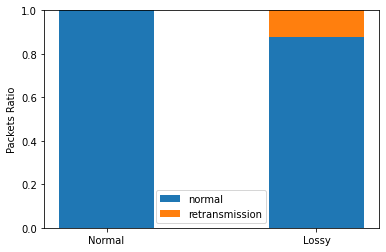

In [22]:
labels = ['Normal', 'Lossy']

width = 0.45  

fig, ax = plt.subplots()

ax.bar(labels, norm_pkts, width, label='normal')
ax.bar(labels, retrans, width, bottom=norm_pkts, label='retransmission')

ax.set_ylabel('Packets Ratio')
ax.legend()

plt.show()

In [54]:
multi_norm = get_connections("zoom/two.pcapng")
multi_loss = get_connections("zoom/two_loss50.pcapng")

+-------------------------------------------+------+-------------+-------------+--------------+--------------+
|                 Connection                | Type | Num Pkt H2R | Num Pkt R2H | Len Data H2R | Len Data R2H |
+-------------------------------------------+------+-------------+-------------+--------------+--------------+
| 172.16.105.110:46195->198.251.134.55:8801 | UDP  |     1696    |     479     |   1742962    |    101845    |
| 172.16.105.110:47020->198.251.134.55:8801 | UDP  |     172     |     162     |    15228     |    13864     |
|  172.16.105.110:50900->198.251.134.55:443 | TCP  |      53     |      57     |     2759     |     2118     |
|       255.255.255.255:67->0.0.0.0:68      | UDP  |      0      |      1      |      0       |     300      |
| 172.16.105.110:36330->198.251.134.55:8801 | UDP  |      8      |      8      |     648      |     648      |
|  255.255.255.255:5678->172.16.105.1:5678  | UDP  |      0      |      1      |      0       |     119      |
+

In [ ]:
labels = ['Normal', 'Lossy']

TCP  = []
UDP1 = []
UDP2 = []
UDP3 = []

width = 0.45  

fig, ax = plt.subplots()

ax.bar(labels, norm_pkts, width, label='normal')
ax.bar(labels, retrans, width, bottom=norm_pkts, label='retransmission')

ax.set_ylabel('Packets Ratio')
ax.legend()

plt.show()

In [36]:
a = rdpcap("zoom/two_loss50.pcapng")
sessions = a.sessions()

In [52]:
a.res[0][IP].src

'172.16.105.110'